# Homework 3: optimization of a CNN model
The task of this homework is to optimize a CNN model for the CIFAR-100. You are free to define the architecture of the model, and the training procedure. The only contraints are:
- It must be a `torch.nn.Module` object
- The number of trained parameters must be less than 1 million
- The test dataset must not be used for any step of training. It is better if don't even import it.
- The final training notebook should run on Google Colab within a maximum 1 hour approximately.

For the grading, you must use the `evaluate` function defined below. It takes a model as input, and returns the test accuracy as output.

As a guideline, you are expected to **discuss** and motivate your choices regarding:
- Model architecture
- Hyperparameters (learning rate, batch size, etc)
- Regularization methods
- Optimizer
- Validation scheme

A code without any explanation of the choices will not be accepted. Test accuracy is not the only measure of success for this homework.

Remember that most of the train process is randomized, store your model's weights after training and load it before the evaluation!

## Example

### Loading packages and libraries

In [3]:
import torch
import torchvision
from evaluate import evaluate

# Import the best device available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
print('Using device:', device)

# load the data
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

Using device: cuda
Files already downloaded and verified


### Example of a simple CNN model

In [ ]:
class TinyNet(torch.nn.Module):
    def __init__(self):
        super(TinyNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(8*8*64, 128)
        self.fc2 = torch.nn.Linear(128, 100)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 8*8*64)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print("Model parameters: ", sum(p.numel() for p in TinyNet().parameters()))

Model parameters:  556708


### Example of basic training

In [ ]:

model = TinyNet()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))


Epoch [1/10], Loss: 4.5927
Epoch [2/10], Loss: 4.5898
Epoch [3/10], Loss: 4.5984
Epoch [4/10], Loss: 4.5864
Epoch [5/10], Loss: 4.5467
Epoch [6/10], Loss: 4.5617
Epoch [7/10], Loss: 4.4748
Epoch [8/10], Loss: 4.2494
Epoch [9/10], Loss: 4.2803
Epoch [10/10], Loss: 3.9809


In [ ]:
# save the model on a file
torch.save(model.state_dict(), 'tiny_net.pt')

loaded_model = TinyNet()
loaded_model.load_state_dict(torch.load('tiny_net.pt', weights_only=True))
evaluate(loaded_model)

The model has 556708 parameters
Accuracy on the test set: 6.36%


- Res net
- bottleneck building block for deeper nets with fast training
- idenitity shortcut
- scheduler for learning rate. study if a plateau is present and in case reduce the lr at plateau
- weight initialization using kaming he initialization (works better than xavier)
- regularization using weight decay: no dropout becauase when using BN it can be avoided
- optimizer: sdg or adam

In [4]:
from typing import Optional
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [5]:
DEVICE = None
if torch.cuda.is_available():
    # Requires NVIDIA GPU with CUDA installed
    DEVICE = torch.device("cuda")
elif torch.mps.is_available():
    # Requires Apple computer with M1 or later chip
    DEVICE = torch.device("mps")
else:
    # Not recommended, because it's slow. Move to Google Colab!
    DEVICE = torch.device("cpu")

print(DEVICE)

cuda


As a first thing I prepare my data. At first I import it without any particular preprocessing. For batch size I use 128 as it can guarantee me good results without an excessive increase of the training time. This size will be kept fixed, i.e. it will not be among the hyperparameters tuned.

I import the training dataset and I split it in training and validation. 4000 samples are used for training and 1000 for validation. The test dataset is not imported to avoid data leakage.

In [6]:
transform = torchvision.transforms.ToTensor()

BATCH_SIZE = 128

# load the train dataset
train_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# Split the dataset into 40k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[40000, 10000],
    generator=torch.Generator().manual_seed(42)
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Files already downloaded and verified


The I define a fit function. This will be used to train the model and it is analog to the one used in the TP.

In [7]:
def train_epoch(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
):
    """
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    """

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = F.cross_entropy(output, target)

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    return running_loss / len(train_dataloader)

def predict(
    model: nn.Module, test_dataloader: DataLoader, device: torch.device, verbose=True
):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction="sum")
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100.0 * correct / len(test_dataloader.dataset)

    if verbose:
        print(
            f"Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)"
        )

    return test_loss, accuracy

def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    scheduler_lr: Optional[torch.optim.lr_scheduler.ReduceLROnPlateau] = None,
    val_dataloader: Optional[DataLoader] = None
):
    """
    Train the model and adjust learning rate dynamically using ReduceLROnPlateau.

    If the validation loss stagnates for 3 reductions, revert the learning rate
    to its original value by multiplying by 1000.
    """
    # Keep track of losses for visualization
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Tracking learning rate changes
    num_lr_reductions = 0
    stagnant_reduction_start_lr = None
    accuracy_at_reduction = None

    stagnant_epochs = 0
    for epoch in range(epochs):
        # Train
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        train_losses.append(train_loss)

        # Validate
        if val_dataloader is not None:
            val_loss, val_accuracy = predict(
                model=model, test_dataloader=val_dataloader, device=device, verbose=False
            )
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print(
                f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.0f}%"
            )
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")

        if scheduler_lr is not None:
            current_lr = optimizer.param_groups[0]['lr']
            scheduler_lr.step(metrics=val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr < current_lr:
              print(f"Learning rate reduced to {new_lr:.6f}")

    return train_losses, val_losses, val_accuracies

In [8]:

def plot_train_val_loss(train_losses, val_losses, ylim=None, loscale=False):
    plt.plot(train_losses, color='red', label='Training Loss')
    plt.plot(val_losses, color='blue', label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(ylim)
    plt.grid()
    plt.legend()
    if loscale:
        plt.yscale("log")
    plt.title("Loss progression across epochs")

The network I choose is a ResNet. As we have seen in the lecture, ResNets are very good network to perform image classification tasks because of their skip connection that prevents gradient vanishing in very deep networks.

For the residual block I use two convolutional layers. The first layer performs also subsampling defined by a stride parameter. For the kernel size I keep it fixed at 3, which is a reasonable number given that images of the CIFAR100 dataset have 32x32 pixels.

After every convolutional layer I apply a batch normalization (BN). As we have seen both in class and during the TP, BN allows to use a higher learning rate without overshooting and thus reaching convergence faster. Moreover, it is an additional way to prevent vanishing gradients and, more in general, unstable ones.

As activation function I use the ReLu, that is widely used for image classification problems.

The network is then built using this residual block.

As a first thing, I pass the image through a 16 filters convolutional layer (with its batch normalization and activation function). Then I instantiate the residual blocks packing them in residual layers.

The first layer has 16 filters, the second 32 and the third 64. The number of blocks per layer are 12, 11 and 10 respectively. As said at the beginning, I want to exploit the depth of the network as much as possible, so I use an over 30 layer resNet, respecting the upper bound of 1 million parameters.

Finally I use an average pooling and a fully connected layer.

To increase performance, I do a weight initialization using Kaiming He normal initialization that we have seen is class is one of the best weight initialization strategy. For the batch normalization and the fully connected layer I do not use any bias.

As of now, I do not use any dropout layer to prevent overfitting. It has been shown that they can safely be safely avoided when using batch normalization. The only form of regulation I use is weight decay as hyperparameter of the optimizer.

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_planes,
            out_channels=planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(
            in_channels=planes,
            out_channels=planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        # Skip connection to match dimensions when necessary
        self.skip = nn.Sequential()
        if stride > 1 or in_planes != planes:
            self.skip = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_planes,
                    out_channels=planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += self.skip(x)
        out = F.relu(out)
        return out

Now I write the network.

In [10]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super().__init__()
        self.in_planes = 16  # Initial number of filters

        # First layer: 3x3 Convolution
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # Residual layers
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        # Global Average Pooling and Fully Connected Layer
        self.linear = nn.Linear(64, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        if out.size(2) > 1 and out.size(3) > 1:
          out = F.avg_pool2d(out, out.size(3))  # Global Average Pooling only if size is >1
        else:
          out = F.adaptive_avg_pool2d(out, (1, 1))  # fallback to adaptive avg pooling if size is too small

        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

print("Model parameters: ", sum(p.numel() for p in ResNet(block=ResidualBlock, num_blocks=[12,11,10]).parameters()))



Model parameters:  986740


To train the model I need an optimizer. Additionally I use also a learning rate scheduler. This allows me to modulate the learning rate according to the state of my loss function. This will help me to reach convergence to a low loss value.

As optimizer I initally use stochastic gradient descent.
As learning rate scheduler I use ReduceLRonPlateu of torch, that detects when we have a plateau in the loss function and reduces the learning rate to have a more precise gradient descent step. The advantage of this scheduler is that it adapts to the condition of the loss function. Moreover, it reduces the learning rate only when it is needed, thus allowing faster convergence.

To correctly tune the hyperparameters a cross validation would be needed, but this would require to train the network for all combinations of them. Since this is really expensive in terms of computing power, I opt to choose some reasonable initial conditions to use as a baseline solution, then based on the results obtained, I will adjust them to directly address the issues I see.

I start with a learning rate of 0.01 a weight decay of 0.001 and momentum of 0.9 in the SDG optimizer. For the scheduler, I use a reduction rate of 0.1 and a patience of 3 epochs (because of the limit on the training time, I do not want to be stuck in a plateau for a lot of epochs).

I begin training with 50 epochs.

Epoch 0: Train Loss=4.4837, Val Loss=4.0854, Val Accuracy=8%
Epoch 1: Train Loss=3.8756, Val Loss=3.7719, Val Accuracy=12%
Epoch 2: Train Loss=3.5514, Val Loss=3.8003, Val Accuracy=13%
Epoch 3: Train Loss=3.2795, Val Loss=3.3043, Val Accuracy=20%
Epoch 4: Train Loss=3.0383, Val Loss=3.0736, Val Accuracy=24%
Epoch 5: Train Loss=2.8316, Val Loss=3.0623, Val Accuracy=24%
Epoch 6: Train Loss=2.6408, Val Loss=2.8178, Val Accuracy=29%
Epoch 7: Train Loss=2.4561, Val Loss=2.7347, Val Accuracy=31%
Epoch 8: Train Loss=2.3101, Val Loss=2.7075, Val Accuracy=31%
Epoch 9: Train Loss=2.1669, Val Loss=2.6385, Val Accuracy=33%
Epoch 10: Train Loss=2.0415, Val Loss=2.5702, Val Accuracy=34%
Epoch 11: Train Loss=1.9256, Val Loss=2.7069, Val Accuracy=33%
Epoch 12: Train Loss=1.8149, Val Loss=2.6920, Val Accuracy=33%
Epoch 13: Train Loss=1.7154, Val Loss=2.5192, Val Accuracy=37%
Epoch 14: Train Loss=1.6355, Val Loss=2.6201, Val Accuracy=36%
Epoch 15: Train Loss=1.5420, Val Loss=2.4172, Val Accuracy=38%
Epo

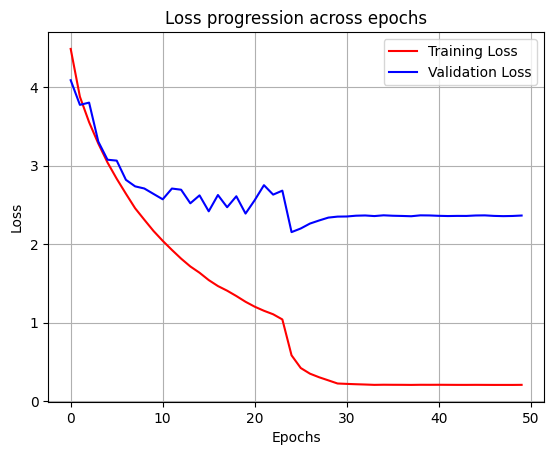

In [11]:
model = ResNet(block=ResidualBlock, num_blocks=[12, 11, 10]).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001, momentum=0.9)
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 50,
        device = DEVICE,
        val_dataloader = valid_dataloader,
        scheduler_lr = scheduler_lr
    )

plot_train_val_loss(train_losses, valid_losses)


The first solution obtained reaches a plateau with a validation accuracy of 45%. More interesting than that is to notice the difference between the training and validation loss, which is a clear case of overfitting.

To address overfitting, I use data augmentation. By slightly modyfying the images of the training set, I introduce more variety in the set which helps the model to generalize better and to perform better on unseen data.
I use just simple transformations such as crop, horizontal flip, rotation and color jitter, which I apply only to the training set because I want to leave the validation set as it is.

In [12]:

# Define a new transform with data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.RandomHorizontalFlip(),    # Randomly flip images horizontally
    transforms.RandomRotation(15),       # Randomly rotate images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color augmentation
    transforms.ToTensor()
])

# No data augmentation for validation
val_transform = transforms.Compose([
    transforms.ToTensor()
])

# Fetch data and apply the new transformer
BATCH_SIZE = 128

# load the train dataset
augmented_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=train_transform)

# Split both the augmented and not augmented dataset,
# but take the training from the augmented and the validation from the not augmented

from torch.utils.data import random_split
train_dataset, valid_dataset_aug = random_split(
    augmented_dataset,
    lengths=[40000, 10000],
    generator=torch.Generator().manual_seed(42)
)

valid_dataset = torch.utils.data.Subset(
    torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        transform=val_transform),
    valid_dataset_aug.indices)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)


Files already downloaded and verified


Epoch 0: Train Loss=4.4802, Val Loss=4.1775, Val Accuracy=6%
Epoch 1: Train Loss=4.0602, Val Loss=4.0516, Val Accuracy=8%
Epoch 2: Train Loss=3.8258, Val Loss=3.7899, Val Accuracy=12%
Epoch 3: Train Loss=3.6274, Val Loss=3.5430, Val Accuracy=16%
Epoch 4: Train Loss=3.4545, Val Loss=3.3125, Val Accuracy=19%
Epoch 5: Train Loss=3.3048, Val Loss=3.1730, Val Accuracy=22%
Epoch 6: Train Loss=3.1579, Val Loss=3.0763, Val Accuracy=24%
Epoch 7: Train Loss=3.0140, Val Loss=3.0380, Val Accuracy=25%
Epoch 8: Train Loss=2.8948, Val Loss=2.8598, Val Accuracy=28%
Epoch 9: Train Loss=2.7733, Val Loss=2.6140, Val Accuracy=32%
Epoch 10: Train Loss=2.6494, Val Loss=2.6205, Val Accuracy=32%
Epoch 11: Train Loss=2.5622, Val Loss=2.6831, Val Accuracy=33%
Epoch 12: Train Loss=2.4726, Val Loss=2.5557, Val Accuracy=34%
Epoch 13: Train Loss=2.3987, Val Loss=2.5327, Val Accuracy=35%
Epoch 14: Train Loss=2.3198, Val Loss=2.5475, Val Accuracy=36%
Epoch 15: Train Loss=2.2540, Val Loss=2.7856, Val Accuracy=33%
Epoc

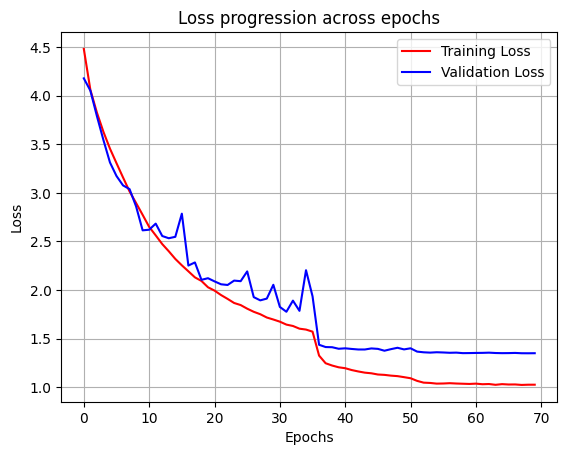

In [13]:

model = ResNet(block=ResidualBlock, num_blocks=[12, 11, 10]).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001, momentum=0.9)
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 70,
        device = DEVICE,
        val_dataloader = valid_dataloader,
        scheduler_lr = scheduler_lr
    )
plot_train_val_loss(train_losses, valid_losses)

Above there is the plot of training and validation losses. Results show that data augmentation was effective: overfitting is considerably reduced and the validation accuracy now reaches 63%.

Now the aim is to tune the hyperparameters to increase the model accuracy.

Looking at the plot, the loss function is well decreasing, then it reaches a plateau that it doesn't manage to escape.

The first modification I do is to start from a learning rate of 0.1 instead of 0.01. Since at the beginning the loss is correctly decreasing, I could use this higher learning rate to make the loss decrease faster where it manages do find a downward path. Then, if it gets stuck in a plateau, the scheduler will intervene to reduce the learning rate.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0: Train Loss=4.6423, Val Loss=4.5460, Val Accuracy=1%
Epoch 1: Train Loss=4.2953, Val Loss=4.4769, Val Accuracy=5%
Epoch 2: Train Loss=4.0224, Val Loss=3.8753, Val Accuracy=10%
Epoch 3: Train Loss=3.8125, Val Loss=3.7332, Val Accuracy=12%
Epoch 4: Train Loss=3.5934, Val Loss=3.5512, Val Accuracy=15%
Epoch 5: Train Loss=3.4121, Val Loss=3.4552, Val Accuracy=17%
Epoch 6: Train Loss=3.2302, Val Loss=3.0763, Val Accuracy=23%
Epoch 7: Train Loss=3.0760, Val Loss=3.0222, Val Accuracy=25%
Epoch 8: Train Loss=2.9645, Val Loss=2.9578, Val Accuracy=26%
Epoch 9: Train Loss=2.8818, Val Loss=2.8503, Val Accuracy=29%
Epoch 10: Train Loss=2.8001, Val Loss=3.0135, Val Accuracy=26%
Epoch 11: Train Loss=2.7334, Val Loss=2.8398, Val Accuracy=29%
Epoch 12: Train Loss=2.6746, Val Loss=2.9103, Val Accuracy=29%
Epoch 13: Train Loss=2.6198, Val Loss=3.0771, Val Accuracy=25%
Epoch 14: Train Loss=2.5802, Val Loss=2.8830, Val Accuracy=30%
Epoch 15: Train Loss=2.5426, Val Loss=2.9238, Val Accuracy=29%
Lear

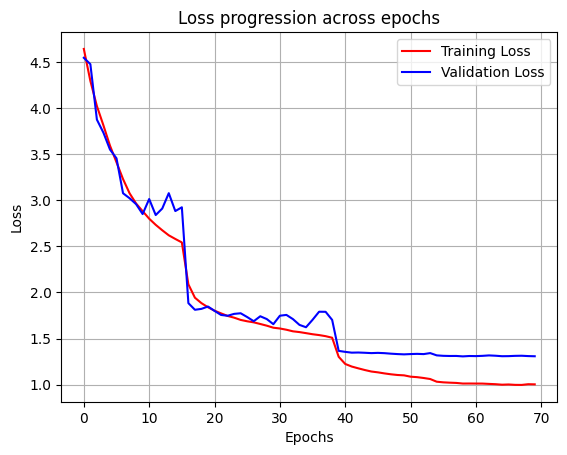

In [ ]:
model = ResNet(block=ResidualBlock, num_blocks=[12, 11, 10]).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001, momentum=0.9)
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, threshold=1e-3, verbose=True)

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 70,
        device = DEVICE,
        val_dataloader = valid_dataloader,
        scheduler_lr = scheduler_lr
    )
torch.save(model.state_dict(), 'resNet_dataAug.pt')
plot_train_val_loss(train_losses, valid_losses)

As we can see from the plot, now the decreasing is not smooth as before, but it is more in steps.

By noticing that, I try a different approach: I want to have more frequent changes of the learning rate but with a lower decreasing factor. To achieve that, I change the decrease factor of the scheduler to 0.5 and the patience to 2 epochs instead of 3.

The idea is to explore a broader range of learning rates, without having a steep decrease to a rate that may be too low and could lead at a stagnation because of the slower convergence

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0: Train Loss=4.6236, Val Loss=4.5618, Val Accuracy=2%
Epoch 1: Train Loss=4.2851, Val Loss=4.4207, Val Accuracy=6%
Epoch 2: Train Loss=3.9555, Val Loss=3.8161, Val Accuracy=11%
Epoch 3: Train Loss=3.6559, Val Loss=3.5636, Val Accuracy=15%
Epoch 4: Train Loss=3.3614, Val Loss=3.3741, Val Accuracy=19%
Epoch 5: Train Loss=3.1363, Val Loss=3.1634, Val Accuracy=22%
Epoch 6: Train Loss=2.9303, Val Loss=2.9191, Val Accuracy=27%
Epoch 7: Train Loss=2.7833, Val Loss=3.2228, Val Accuracy=24%
Epoch 8: Train Loss=2.6561, Val Loss=3.2927, Val Accuracy=24%
Epoch 9: Train Loss=2.5679, Val Loss=2.5988, Val Accuracy=33%
Epoch 10: Train Loss=2.4897, Val Loss=3.1472, Val Accuracy=26%
Epoch 11: Train Loss=2.4506, Val Loss=2.9333, Val Accuracy=29%
Epoch 12: Train Loss=2.4095, Val Loss=2.8213, Val Accuracy=31%
Learning rate reduced to 0.050000
Epoch 13: Train Loss=2.1126, Val Loss=2.3053, Val Accuracy=40%
Epoch 14: Train Loss=2.0617, Val Loss=2.2081, Val Accuracy=43%
Epoch 15: Train Loss=2.0551, Val 

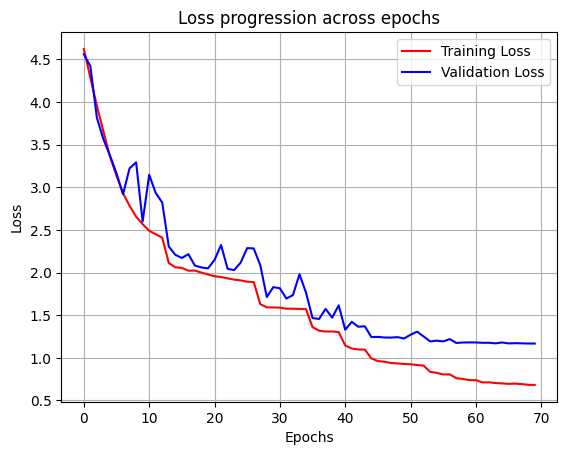

In [ ]:
model = ResNet(block=ResidualBlock, num_blocks=[12, 11, 10]).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001, momentum=0.9, nesterov=True)
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, threshold=1e-3, verbose=True)

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 70,
        device = DEVICE,
        val_dataloader = valid_dataloader,
        scheduler_lr = scheduler_lr
    )
torch.save(model.state_dict(), 'resNet_dataAug_nesterov_0p5SchedulerFactor.pt')
plot_train_val_loss(train_losses, valid_losses)

The results obtained show that there has been a slight improvement, reaching a validation accuracy of 68%.

At this point I take this as the best model and I asses its performance on the test set.

In [ ]:
loaded_model = ResNet(block=ResidualBlock, num_blocks=[12, 11, 10])
loaded_model.load_state_dict(torch.load('resNet_dataAug_nesterov_0p5SchedulerFactor.pt', weights_only=True))
evaluate(loaded_model)

The model has 986740 parameters
Accuracy on the test set: 69.32%


Additional: reduce overfitting.

As we can notice from all the plots, after a certain number of epochs the training loos decreases more than the validation loss and it reaches a plateau later and at a lower value. It would be nice to make the validation loss follow better the training loss, to make it decrease more.

To do that I implement a dropout solution that counteracts overfitting. The soolution chosen howevere is not a classical dropout, but a layer called dropblock.

Dropblock has been introduced in CITATION as a form of dropout specific for CNN. The idea is that, instead of using a dropout technique on the last fully connected layer we put the dropblock right after a convolutional layer and a certain block of the image will be discarded from the training according to a certain probability.

In my implementation I put the droblock inside the residual block in between the two convolutions and in the complete net after the first convolution.

In [ ]:
class ResidualBlock_drop(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_planes,
            out_channels=planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(
            in_channels=planes,
            out_channels=planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        # Dropblock
        self.dropblock = torchvision.ops.DropBlock2d(p=0.1, block_size=7)

        # Skip connection to match dimensions when necessary
        self.skip = nn.Sequential()
        if stride > 1 or in_planes != planes:
            self.skip = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_planes,
                    out_channels=planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.dropblock(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.skip(x)
        out = F.relu(out)
        return out

In [ ]:
class ResNet_drop(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super().__init__()
        self.in_planes = 16  # Initial number of filters

        # First layer: 3x3 Convolution
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # Residual layers
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        # Global Average Pooling and Fully Connected Layer
        self.linear = nn.Linear(64, num_classes)

        # Dropblock
        self.dropblock = torchvision.ops.DropBlock2d(p=0.1, block_size=7)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropblock(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        if out.size(2) > 1 and out.size(3) > 1:
          out = F.avg_pool2d(out, out.size(3))  # Global Average Pooling only if size is >1
        else:
          out = F.adaptive_avg_pool2d(out, (1, 1))  # fallback to adaptive avg pooling if size is too small

        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

print("Model parameters: ", sum(p.numel() for p in ResNet(block=ResidualBlock, num_blocks=[12,11,10]).parameters()))



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0: Train Loss=4.4449, Val Loss=4.1515, Val Accuracy=5%
Epoch 1: Train Loss=4.0936, Val Loss=3.9872, Val Accuracy=8%
Epoch 2: Train Loss=3.8698, Val Loss=3.6292, Val Accuracy=13%
Epoch 3: Train Loss=3.6380, Val Loss=3.4890, Val Accuracy=17%
Epoch 4: Train Loss=3.4454, Val Loss=3.1892, Val Accuracy=22%
Epoch 5: Train Loss=3.2733, Val Loss=3.3409, Val Accuracy=21%
Epoch 6: Train Loss=3.1134, Val Loss=3.6036, Val Accuracy=20%
Epoch 7: Train Loss=2.9863, Val Loss=3.0851, Val Accuracy=24%
Epoch 8: Train Loss=2.8732, Val Loss=2.7636, Val Accuracy=31%
Epoch 9: Train Loss=2.7709, Val Loss=2.6222, Val Accuracy=31%
Epoch 10: Train Loss=2.6987, Val Loss=2.6265, Val Accuracy=33%
Epoch 11: Train Loss=2.6312, Val Loss=2.6454, Val Accuracy=33%
Epoch 12: Train Loss=2.5826, Val Loss=2.6180, Val Accuracy=33%
Epoch 13: Train Loss=2.5433, Val Loss=2.8578, Val Accuracy=30%
Epoch 14: Train Loss=2.5093, Val Loss=2.5171, Val Accuracy=36%
Epoch 15: Train Loss=2.4840, Val Loss=2.4904, Val Accuracy=37%
Epoc

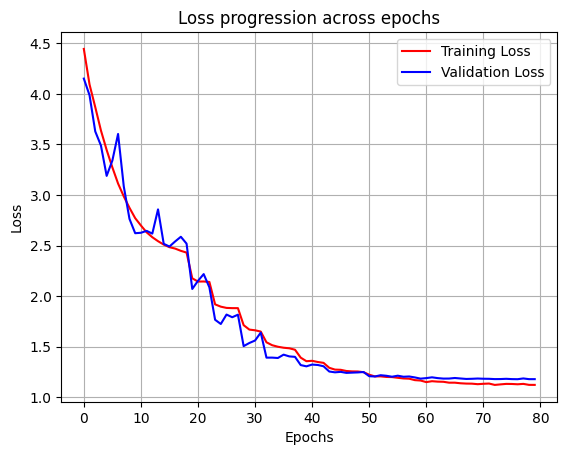

In [ ]:
model = ResNet_drop(block=ResidualBlock_drop, num_blocks=[12, 11, 10]).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001, momentum=0.9, nesterov=True)
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, threshold=1e-3, verbose=True)

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 80,
        device = DEVICE,
        val_dataloader = valid_dataloader,
        scheduler_lr = scheduler_lr
    )
torch.save(model.state_dict(), 'resNet_dropBlock.pt')
plot_train_val_loss(train_losses, valid_losses)

Results show actually a reduction of overfitting ad the training and validation losses are close to each other for the whole training. The accuracy howevere is slightly less (2% less than before), probably due to the bias introduced. Indeed, the training loss in this case is higher than without the dropblock.

Despite that, it is interesting to see how the dropblock is effective and potentially, with a longer training time, it could lead to better results.



In [ ]:
evaluate(model)

The model has 986740 parameters
Accuracy on the test set: 66.37%
